# Look at climate change in MPI

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import seaborn as sns
import xarray as xr
import warnings
import tqdm
import pathlib
import cmocean
import os

# Import custom modules
import src.utils
from src.XRO import XRO, xcorr

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def plot_hov(ax, data, amp, label=None):
    """Plot hovmoller of longitude vs. year"""

    # kwargs = dict(levels=src.utils.make_cb_range(3, 0.3), cmap="cmo.balance", extend="both")
    plot_data = ax.contourf(
        data.longitude,
        data.year,
        data.T,
        cmap="cmo.balance",
        extend="both",
        levels=src.utils.make_cb_range(amp, amp / 10),
    )
    cb = fig.colorbar(
        plot_data, orientation="horizontal", ticks=[-amp, 0, amp], label=label
    )

    ## label
    kwargs = dict(ls="--", c="w", lw=0.8)
    for ax in axs:
        ax.set_xlabel("Longitude")
        ax.set_xticks([190, 240])
        ax.set_yticks([])
        ax.axvline(190, **kwargs)
        ax.axvline(240, **kwargs)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    return


def plot_hov2(ax, data, amp, label=None):
    """Plot hovmoller of longitude vs. year"""

    # kwargs = dict(levels=src.utils.make_cb_range(3, 0.3), cmap="cmo.balance", extend="both")
    plot_data = ax.contourf(
        data.month,
        data.year,
        data.T,
        cmap="cmo.balance",
        extend="max",
        levels=src.utils.make_cb_range(amp, amp / 10),
    )
    cb = fig.colorbar(
        plot_data, orientation="horizontal", ticks=[-amp, 0, amp], label=label
    )

    ## label
    kwargs = dict(ls="--", c="w", lw=0.8)
    for ax in axs:
        ax.set_xlabel("Month")
        ax.set_xticks([1, 12])
        ax.set_yticks([])
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    return


def get_rolling_var(data, n=10):
    """
    Get variance, computing over time and ensemble member. To increase
    sample size for variance estimate, compute over time window of 2n+1
    years, centered at given year.
    """

    return src.utils.get_rolling_fn_bymonth(data, fn=np.var, n=n)

## Change in $T$, $h$

### Load data
And compute variance/skewness

In [3]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

## get rolling variance, by month
Th_var = get_rolling_var(Th, n=15)
Th_var_bymonth = src.utils.unstack_month_and_year(Th_var)

## get rolling skew, by month
Th_skew = src.utils.get_rolling_fn_bymonth(Th, fn=scipy.stats.skew, n=15)
Th_skew_bymonth = src.utils.unstack_month_and_year(Th_skew)

## Get % increase in variance
baseline = Th_var_bymonth.isel(year=slice(None, 30)).mean("year")
Th_var_bymonth_pct = 100 * (Th_var_bymonth - baseline) / baseline

### Variance

Hövmöller

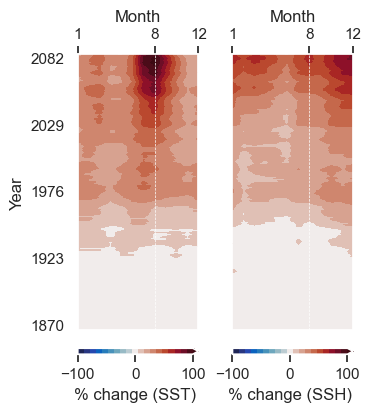

In [4]:
## setup plot
fig, axs = plt.subplots(1, 2, figsize=(3.6, 4), layout="constrained")

## plot T data
plot_hov2(axs[0], Th_var_bymonth_pct["T_34"].T, amp=100, label="% change (SST)")
plot_hov2(axs[1], Th_var_bymonth_pct["h"].T, amp=100, label="% change (SSH)")

## label
xticks = np.linspace(1870, 2082, 5)
axs[0].set_yticks(xticks)
axs[0].set_ylabel("Year")
axs[1].set_ylim(axs[0].get_ylim())
for ax in axs:
    ax.axvline(8, ls="--", c="w", alpha=1, lw=0.5)
    ax.set_xticks([1, 8, 12])

plt.show()

Compare August and December variance over time

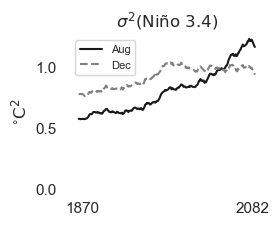

In [5]:
fig, ax = plt.subplots(figsize=(2.5, 2))

## plot data
ax.plot(
    Th_var_bymonth.year, Th_var_bymonth["T_34"].sel(month=8), label="Aug", c="k", ls="-"
)
ax.plot(
    Th_var_bymonth.year,
    Th_var_bymonth["T_34"].sel(month=11),
    label="Dec",
    c="gray",
    ls="--",
)

## label and style
ax.set_title(r"$\sigma^2\left(\text{Niño 3.4}\right)$")
ax.set_ylim([0, None])
ax.set_xticks(xticks[[0, -1]])
ax.legend(prop=dict(size=8))
ax.set_ylabel(r"$^{\circ}\text{C}^2$")

plt.show()

### Skewness

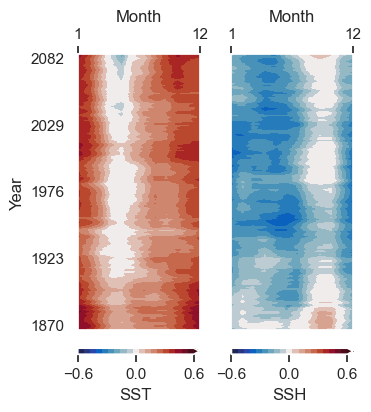

In [6]:
## setup plot
fig, axs = plt.subplots(1, 2, figsize=(3.6, 4), layout="constrained")

## plot T data
plot_hov2(axs[0], Th_skew_bymonth["T_34"].T, amp=0.6, label="SST")
plot_hov2(axs[1], Th_skew_bymonth["h"].T, amp=0.6, label="SSH")

## label
axs[0].set_yticks(np.linspace(1870, 2082, 5))
axs[0].set_ylabel("Year")
axs[1].set_ylim(axs[0].get_ylim())
plt.show()

### Seasonality

## Change in spatial patterns

In [7]:
## specify sliding window size for climatology
n_years = 3

## Load EOF data
eofs_fp = pathlib.Path(DATA_FP, "mpi", "eofs300")
eofs_sst = src.utils.load_eofs(eofs_fp / "ts.nc")
eofs_ssh = src.utils.load_eofs(eofs_fp / "ssh.nc")

## for convenience, put components and scores into datasets
components = xr.merge(
    [eofs_sst.components().rename("sst"), eofs_ssh.components().rename("ssh")]
)
scores = xr.merge([eofs_sst.scores().rename("sst"), eofs_ssh.scores().rename("ssh")])

## get forced/anomalous component
forced, anom = src.utils.separate_forced(scores, n=n_years)

### Reconstruct equatorial strip

In [8]:
## get rolling avg
forced_rolling = src.utils.get_rolling_avg(forced, n=1)

## get NDJ season
month = forced_rolling.time.dt.month
forced_ndj = forced_rolling.isel(time=(month == 12))

## reconstruct equatorial average
eq_avg = lambda x: x.sel(latitude=slice(-2, 2), longitude=slice(125, 279)).mean(
    "latitude"
)
kwargs = dict(scores=forced_ndj, components=components, fn=eq_avg)
forced_ndj_recon = src.utils.reconstruct_fn(**kwargs)

## replace time axis with year for easier plotting
forced_ndj_recon["time"] = forced_ndj_recon["time"].dt.year
forced_ndj_recon = forced_ndj_recon.rename({"time": "year"})

## subtract leading 30-year mean
clim = forced_ndj_recon.isel(year=slice(None, 30)).mean("year")
forced_anom = forced_ndj_recon - clim

### Hövmöller plot

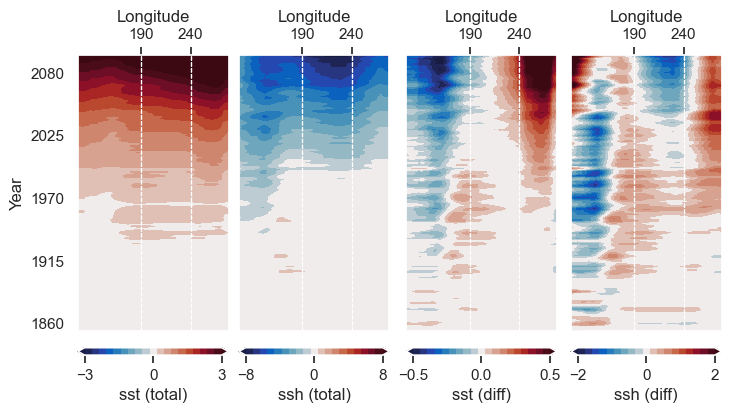

In [9]:
## setup plot
fig, axs = plt.subplots(1, 4, figsize=(7.2, 4), layout="constrained")

for j, (varname, total_amp, diff_amp) in enumerate(
    zip(["sst", "ssh"], [3, 8], [0.5, 2])
):

    ## get total plot and difference
    total = forced_anom[varname]
    diff = total - total.mean("longitude")

    ## plot data
    plot_hov(axs[j], total, amp=total_amp, label=f"{varname} (total)")
    plot_hov(axs[j + 2], diff, amp=diff_amp, label=f"{varname} (diff)")

axs[0].set_yticks(np.arange(1860, 2100, 55))
axs[0].set_ylabel("Year")
plt.show()

### Line plots

Function to do formatting. Not sure about units for SSH: data attribute says "m", but data itself suggests "cm"...

In [10]:
def format_line_plots(axs):
    """format subplots"""

    for ax in axs[0, :]:
        ax.set_xticks([])
    # for ax in axs[:, 1]:
    #     ax.yaxis.tick_right()
    axs[1, 0].set_xticks([1860, 1970, 2080])
    axs[0, 2].set_yticks([-0.5, 0.5])
    axs[1, 2].set_yticks([-4, 4])
    axs[0, 1].set_yticks([-3, 3])
    axs[1, 1].set_yticks([-24, 24])
    axs[0, 0].set_yticks([25.5, 28.5])
    axs[1, 0].set_yticks([91, 84])
    axs[0, 0].set_ylabel(r"SST ($^{\circ}$C)")
    axs[1, 0].set_ylabel(r"SSH (cm?)")
    axs[0, 0].set_title("Zonal mean")
    axs[0, 1].set_title("Zonal anomaly")
    axs[0, 2].set_title("Change (late minus early)")
    axs[1, 0].set_xlabel("Year")
    for ax in axs[1, 1:]:
        ax.set_xticks([140, 210, 280])
        ax.set_xlabel("Longitude")

    for ax in axs[:, 2]:
        kwargs = dict(ls="--", lw=0.5, c="k")
        ax.axhline(0, **kwargs)
        ax.axvspan(160, 210, color="b", alpha=0.15, label="4")
        ax.axvspan(190, 240, color="r", alpha=0.15, label="3.4")

    ## scale axes
    for j in [0, 1]:
        axs[j, 2].set_ylim(1 / 6 * np.array(axs[j, 1].get_ylim()))

    ## legends
    axs[0, 1].legend(prop=dict(size=6))
    axs[1, 2].legend(prop=dict(size=6), loc="upper right")

    return

Make plot

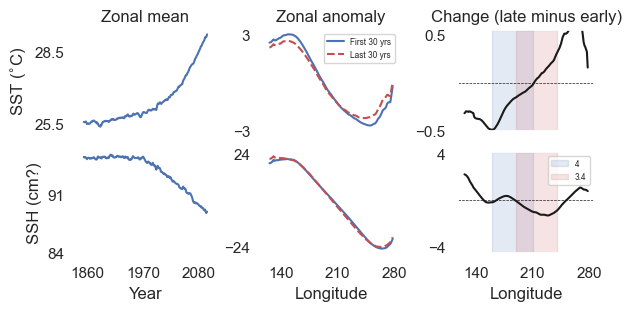

In [11]:
## get zonal mean, tilt, and grad
zonal_mean = forced_ndj_recon.mean("longitude")
tilt = forced_ndj_recon - zonal_mean
grad = tilt.differentiate(coord="longitude")

## get plot style for beginning/end periods
start_kwargs = dict(color="b", ls="-", label="First 30 yrs")
end_kwargs = dict(color="r", ls="--", label="Last 30 yrs")
t_idxs = [slice(None, 30), slice(-30, None)]

## make plot
fig, axs = plt.subplots(2, 3, figsize=(6, 3), layout="constrained")

## plot SST and SSH on separate rows
for j, varname in enumerate(["sst", "ssh"]):

    ## plot zonal mean
    axs[j, 0].plot(zonal_mean.year, zonal_mean[varname])

    ## tilt at beginning and end of period
    tilts = [tilt[varname].isel(year=t_).mean("year") for t_ in t_idxs]

    ## plot diff from zonal mean
    for tilt_, plot_kwargs in zip(tilts, [start_kwargs, end_kwargs]):

        ## tilt
        axs[j, 1].plot(tilt.longitude, tilt_, **plot_kwargs)

    ## plot change
    axs[j, 2].plot(diff.longitude, tilts[1] - tilts[0], c="k")


## label/format plot
format_line_plots(axs)

plt.show()

### Change in variance

#### Equatorial region

In [12]:
def get_var(data, year_center, n=15, fn=None):
    """
    Reconstruct variance for given time period.
    Estimate variance based on window centered on `year_center'.
    Window encompasses all samples within 'n' years of year_center.
    """

    ## get indices of samples in window
    in_window = np.abs(data.time.dt.year - year_center) <= n

    ## get variance of samples in window
    kwargs = dict(components=components, scores=data.isel(time=in_window), fn=fn)
    data_var = src.utils.reconstruct_var(**kwargs)

    return data_var


def get_var_bymonth(data, year_center, n=15, fn=None):
    """Get variance by month"""

    ## function to apply to each month
    kwargs = dict(year_center=year_center, n=n, fn=fn)
    get_var_ = lambda x: get_var(x, **kwargs)
    return data.groupby("time.month").map(get_var_)


def get_var_for_periods(data, periods, n=15, fn=None, by_month=True):
    """get variance for specified periods"""

    ## get arguments for variance reconstruction
    kwargs = dict(data=data, n=n, fn=fn)

    ## get variance recon func
    get_var_fn = get_var_bymonth if by_month else get_var
    var_by_period = [get_var_fn(year_center=y, **kwargs) for y in tqdm.tqdm(periods)]

    ## get dimension to represent period_centers
    period_dim = pd.Index(periods, name="period")

    ## put in array
    return xr.concat(var_by_period, dim=period_dim)


## get variance by period
period_centers = np.array([1868, 1939, 2010, 2082])

## Get equatorial strip variance
kwargs = dict(data=anom, periods=period_centers, n=15, fn=eq_avg)
var_by_period_eq = get_var_for_periods(**kwargs)

# ## Get variance over broader range of latitudes (for all months
kwargs = dict(kwargs, fn=None, periods=period_centers[[0, -1]], by_month=False)
var_by_period = get_var_for_periods(**kwargs)
# var_by_period = xr.concat([
#     get_var(anom, year_center=p) for p in period_centers[[0,-1]]
# ], concat_dim

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.40s/it]


Set plot style for plots

In [13]:
def label_axs(axs):
    """label axs for variance plot"""
    axs[0].legend(prop=dict(size=6))
    axs[0].set_title("SST")
    axs[1].set_title("SSH")
    axs[0].set_ylabel(r"$^{\circ}$C$^2$")
    axs[1].set_ylabel(r"cm$^2$")
    axs[0].set_yticks([0, 1, 2])
    axs[1].set_yticks([0, 35, 70])
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_label_position("right")
    for ax in axs:
        ax.set_xlabel("Longitude")

    return


def add_xticks(ax, ticks):
    """add tick labels in specified positions"""
    ax.set_xticks(ticks)
    for tick in ticks:
        ax.axvline(tick, ls="--", c="k", lw=0.5)
    return

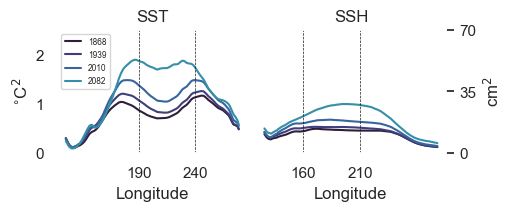

In [14]:
## select month for plot
month = 8

## colorbar
colors = sns.color_palette("mako")

## set up plot
fig, axs = plt.subplots(1, 2, figsize=(5, 2), layout="constrained")

for j, (p, c) in enumerate(zip(var_by_period_eq.period, colors)):

    ## Get subset of data for period
    plot_data = var_by_period_eq.sel(period=p, month=month)

    ## plot
    lon = var_by_period_eq.longitude
    axs[0].plot(lon, plot_data["sst"], label=f"{period_centers[j]}", c=c)
    axs[1].plot(lon, plot_data["ssh"], c=c)

## format/label axes
label_axs(axs)
add_xticks(axs[0], [190, 240])
add_xticks(axs[1], [160, 210])

axs[0].set_ylim([0, 2.5])

plt.show()

#### Spatial (Hovmoller)

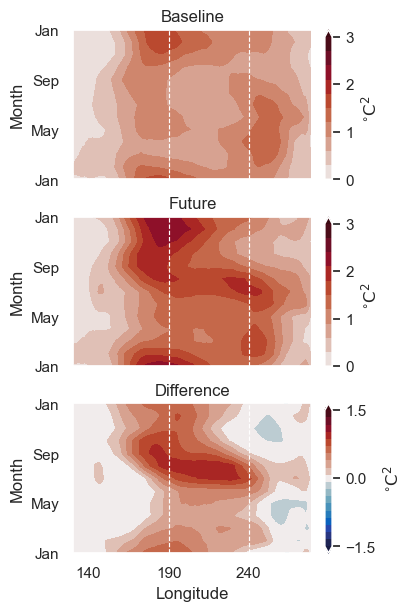

In [15]:
## get plot data
baseline = var_by_period_eq["sst"].isel(period=0)
future = var_by_period_eq["sst"].isel(period=-1)
change = future - baseline

## shared args for plotting
plot_kwargs = dict(cmap="cmo.amp", extend="max")

## Set up plot
fig, axs = plt.subplots(3, 1, figsize=(4, 6), layout="constrained")

## make hövmöllers
cp0 = src.utils.plot_cycle_hov(
    axs[0], baseline, levels=np.arange(0, 3.3, 0.3), **plot_kwargs
)
cp1 = src.utils.plot_cycle_hov(
    axs[1], future, levels=np.arange(0, 3.3, 0.3), **plot_kwargs
)
cp2 = src.utils.plot_cycle_hov(
    axs[2],
    change,
    levels=src.utils.make_cb_range(1.5, 0.15),
    cmap="cmo.balance",
    extend="both",
)

## label
axs[0].set_title("Baseline")
axs[1].set_title("Future")
axs[2].set_title("Difference")
axs[-1].set_xlabel("Longitude")
axs[-1].set_xticks([140, 190, 240])

## add colorbars
kwargs = dict(ticks=[0, 1, 2, 3], label=r"$^{\circ}\text{C}^2$")
cb0 = fig.colorbar(cp0, ax=axs[0], **kwargs)
cb1 = fig.colorbar(cp1, ax=axs[1], **kwargs)
cb2 = fig.colorbar(cp2, ax=axs[2], **dict(kwargs, ticks=[-1.5, 0, 1.5]))

plt.show()

#### Spatial

Compute

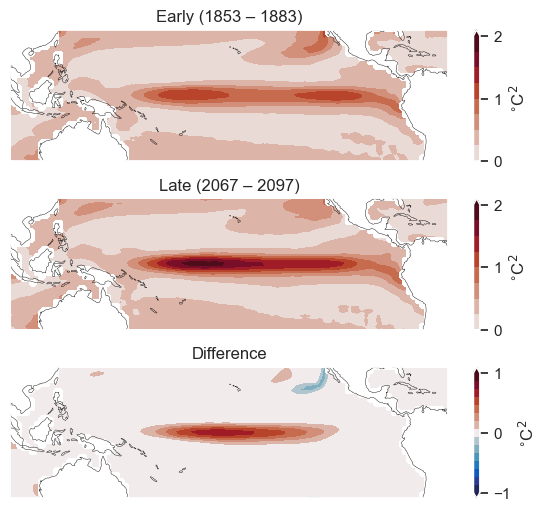

In [16]:
## set up paneled subplot
fig = plt.figure(figsize=(6, 5), layout="constrained")
axs = src.utils.subplots_with_proj(
    fig, nrows=3, ncols=1, format_func=src.utils.plot_setup_pac
)

## plot data
kwargs = dict(
    var0=var_by_period["sst"].isel(period=0),
    var1=var_by_period["sst"].isel(period=-1),
    amp=2,
    amp_diff=1,
    show_colorbars=True,
    cbar_label=r"$^{\circ}$C$^2$",
)
fig, axs = src.utils.make_variance_subplots(fig, axs, **kwargs)
axs[0, 0].set_title("Early (1853 – 1883)")
axs[1, 0].set_title("Late (2067 – 2097)")
axs[2, 0].set_title("Difference")

plt.show()

## Change in zonal gradient

### Compute zonal gradient

In [16]:
def get_zonal_grad(x):
    """
    Function to compute zonal gradient. Ref: Fig 7 in Maher et al, 2023.
    """

    ## outlines for boxes
    ebox_coords = dict(longitude=slice(210, 270), latitude=slice(-5, 5))
    wbox_coords = dict(longitude=slice(120, 180), latitude=slice(-5, 5))

    ## compute box averages
    ebox_avg = src.utils.spatial_avg(x.sel(ebox_coords))
    wbox_avg = src.utils.spatial_avg(x.sel(wbox_coords))

    return ebox_avg - wbox_avg

In [17]:
## compute zonal gradient
zonal_grad_forced = src.utils.reconstruct_fn(components, forced, fn=get_zonal_grad)

## sep. time into year and month
zonal_grad_forced_bymonth = src.utils.unstack_month_and_year(zonal_grad_forced)

## get change from initial climatology
clim = zonal_grad_forced_bymonth.isel(year=slice(None, 30)).mean("year")
zonal_grad_change = zonal_grad_forced_bymonth - clim

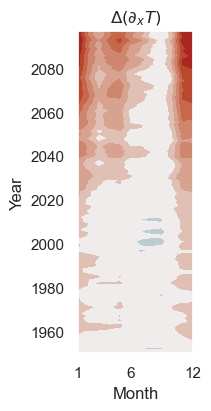

In [18]:
## setup plot
fig, ax = plt.subplots(figsize=(2, 4), layout="constrained")

## plot data
kwargs = dict(levels=src.utils.make_cb_range(1, 0.1), cmap="cmo.balance")
plot_data = ax.contourf(
    zonal_grad_change.month, zonal_grad_change.year, zonal_grad_change["sst"], **kwargs
)

## label
ax.set_ylabel("Year")
ax.set_xlabel("Month")
ax.set_xticks([1, 6, 12])
ax.set_title(r"$\Delta \left(\partial_x T\right)$")
ax.set_ylim([1950, None])

plt.show()

## Look at mean state-dependence

### Compare Bjerknes growth rate to zonal gradient

#### Load $T,h$ data

In [19]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

#### Fit RO to $T,h$ data

In [20]:
## get subset of data
Th_sub = Th.sel(time=slice("1979", "2024"))

## initialize model
model = XRO(ncycle=12, ac_order=3, is_forward=True)

## fit to individual ensemble members
kwargs = dict(model=model, T_var="T_3", h_var="h_w", verbose=True)
_, fits = src.utils.get_RO_ensemble(Th_sub, **kwargs)

## extract parameters
params = model.get_RO_parameters(fits)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.43it/s]


#### Look at intra-ensemble spread
$\partial_x T$ vs. BJ index  
Compare to Maher et al (2023)

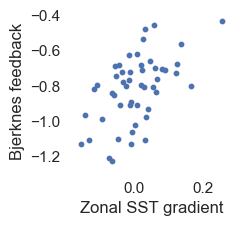

In [21]:
## get subset of data to look at
anom_ = anom.sel(time=slice("1979", "2024"))

## compute zonal gradient at every time step
zonal_grad = src.utils.reconstruct_fn(components, anom_, fn=get_zonal_grad)

## get monthly avg
zonal_grad_by_month = zonal_grad.groupby("time.month").mean()

fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(zonal_grad_by_month["sst"].mean("month"), params["R"].mean("cycle"), s=10)
ax.set_xlabel("Zonal SST gradient")
ax.set_ylabel("Bjerknes feedback")
plt.show()